In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import dataset_handler
from dataset_handler import *
import progressbar
from IR_analysis import dewarp_data, get_dewarp_parameters, sort_corner_points,dewarp_exp
from DataTypes import IrData,ImageData
from datetime import datetime
import user_config as ucfg
import cv2

from multiprocessing import Pool
import multiprocessing as mp
from scipy.interpolate import RectBivariateSpline
%load_ext autoreload
%autoreload 2

In [2]:
points = [(120,450),(370,460),(120,260),(370,263)]

In [3]:
data = ImageData(os.path.join(ucfg.get_path('data_folder')),image_extension='jpg')
MEASUREMENT_NAME = 'test2'
points = [(290,190),(130,745),(1215,180),(1362,740)]
start, end = 0, len(data.data_numbers)
TARGET_RATIO = 1
selected_points = points

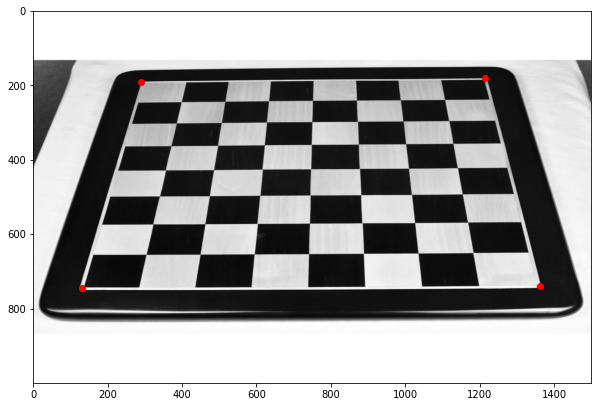

In [169]:

plt.figure(figsize=(10,10))
plt.imshow(data.get_frame(0),cmap='gray',aspect='equal')
plt.scatter([p[0] for p in points],[p[1] for p in points],c='r')

In [5]:

def create_dataset(MEASUREMENT_NAME, selected_points,TARGET_RATIO, start, end):
    dewarp_params = get_dewarp_parameters(sort_corner_points(selected_points), target_ratio=TARGET_RATIO)
    
    h5_file = create_h5_file(f'{MEASUREMENT_NAME}')
    grp = h5_file['dewarped_data']
    grp.attrs['transformation_matrix'] = dewarp_params['transformation_matrix']
    grp.attrs['target_pixels_width'] = dewarp_params['target_pixels_width']
    grp.attrs['target_pixels_height'] = dewarp_params['target_pixels_height']
    grp.attrs['target_ratio'] = TARGET_RATIO
    grp.attrs['selected_points'] = selected_points
    grp.attrs['frame_range'] = (start, end)
    grp.attrs['points_selection_date'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    dset_h,dset_w = dewarp_params['target_pixels_height'], dewarp_params['target_pixels_width']
    grp.create_dataset('data',
              (dset_h, dset_h, 1),
                maxshape=(dset_h, dset_w, None),
                chunks=(dset_h, dset_w, 1),
                dtype=np.float32)
    dataset_handler.close_file()

In [15]:
create_dataset('test', selected_points, TARGET_RATIO, start, end)
src_x,src_y =dewarp_exp('test', data,1)

  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


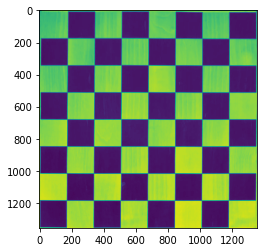

In [8]:
import matplotlib.pyplot as plt
plt.imshow(get_dewarped_data('test')[:,:,0])
dataset_handler.close_file()

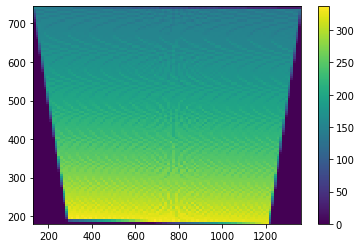

In [171]:
plt.hist2d(src_x.flatten(),src_y.flatten(),bins=100)
plt.colorbar()

In [71]:
src_x

array([[ 290.        ,  290.67505649,  291.35012408, ..., 1212.92900643,
        1213.61932614, 1214.30965733],
       [ 289.91117004,  290.58634931,  291.26153968, ..., 1213.00993091,
        1213.70037901, 1214.3908386 ],
       [ 289.82230758,  290.49760966,  291.17292286, ..., 1213.09088534,
        1213.78146188, 1214.47204991],
       ...,
       [ 130.4706368 ,  131.36575523,  132.26089322, ..., 1358.79946277,
        1359.72161998, 1360.64379764],
       [ 130.31383414,  131.20916844,  132.10452232, ..., 1358.94337207,
        1359.8657584 , 1360.78816519],
       [ 130.15695522,  131.05250551,  131.94807538, ..., 1359.08735241,
        1360.00996797, 1360.932604  ]])

In [72]:
src_y

array([[190.        , 189.99270209, 189.98540406, ..., 180.02238912,
        180.0149262 , 180.00746316],
       [190.30812891, 190.3008322 , 190.29353537, ..., 180.33213665,
        180.32467493, 180.31721308],
       [190.61637059, 190.60907508, 190.60177945, ..., 180.64199881,
        180.63453828, 180.62707764],
       ...,
       [743.3674786 , 743.363828  , 743.36017732, ..., 738.35793333,
        738.35417245, 738.3504115 ],
       [743.91138784, 743.9077423 , 743.90409667, ..., 738.90876233,
        738.90500664, 738.90125087],
       [744.45556158, 744.45192109, 744.44828053, ..., 739.45986322,
        739.45611272, 739.45236213]])

In [74]:
src_points = np.array([src_x.flatten(),src_y.flatten()]).reshape(-1,*src_x.shape).T
src_points.shape

(1355, 1355, 2)

In [135]:
src_points[0,0:6]

array([[290.        , 190.        ],
       [289.91117004, 190.30812891],
       [289.82230758, 190.61637059],
       [289.73341258, 190.9247251 ],
       [289.64448505, 191.2331925 ],
       [289.55552494, 191.54177285]])

In [136]:
np.diff(src_points[0,0:6],axis=0)

array([[-0.08882996,  0.30812891],
       [-0.08886247,  0.30824168],
       [-0.08889499,  0.30835451],
       [-0.08892754,  0.3084674 ],
       [-0.0889601 ,  0.30858036]])

In [137]:
np.linalg.norm(np.diff(src_points[0,0:6],axis=0),axis=1)

array([0.3206777 , 0.32079506, 0.32091248, 0.32102997, 0.32114753])

In [162]:
np.linalg.norm(src_points[0,1] - src_points[-1,1])

924.5336532362192

In [138]:
diff_in_y = np.linalg.norm(np.diff(src_points,axis=1),axis=2)
diff_in_x = np.linalg.norm(np.diff(src_points,axis=0),axis=2)

In [139]:
diff_in_y[0]

array([0.3206777 , 0.32079506, 0.32091248, ..., 0.5657853 , 0.56606037,
       0.56633563])

In [149]:
np.argmax(diff_in_x)

1834669

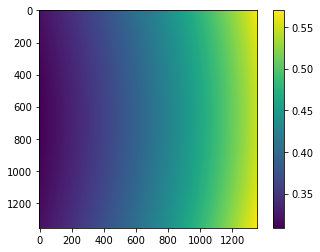

In [144]:
plt.imshow(diff_in_y)
plt.colorbar()

In [1]:
plt.imshow(diff_in_x.T)
plt.colorbar()

NameError: name 'plt' is not defined

In [166]:
np.sum(diff_in_x,axis=0)[-1]  

1230.785817938914

In [168]:
np.sum(diff_in_y,axis=1)[0]  

577.0361936016748

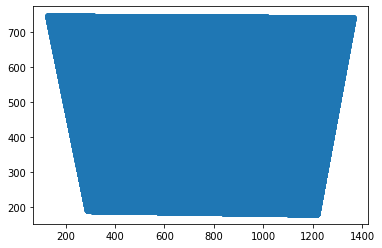

In [173]:
plt.scatter(*src_points.T)